# Pixel Operations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage
import imageio
import cv2 as cv

## Histogram Manipulations

In [2]:
url = '' #'https://upload.wikimedia.org/wikipedia/commons/0/08/Unequalized_Hawkes_Bay_NZ.jpg'
url_file = 'python/data/300px-Unequalized_Hawkes_Bay_NZ.jpg'

In [3]:
try:
    im = imageio.imread(url)
    print ('image loaded from ', url)
except:
    im = imageio.imread(url_file)
#
print ('image loaded: ', im.shape)

image loaded:  (200, 300)


In [4]:
if len(im.shape) == 3:
    print ('color channel image -- we only use the first channel: ', im.shape)
    im = im[:,:,0]
    print (im.shape, ' first pixel: ', im[0,0])

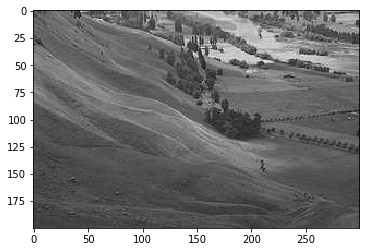

In [5]:
plt.imshow (im, cmap='gray')

## 1. histogram computation

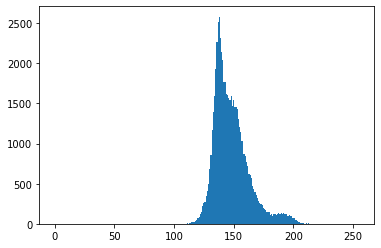

In [6]:
h = plt.hist (im.ravel(), bins=256, range=(0,255))

In [7]:
count = np.zeros (256, dtype=np.int)
count.shape

(256,)

In [8]:
for r in range(im.shape[0]):
    for c in range(im.shape[1]):
        count[ im[r,c] ] += 1

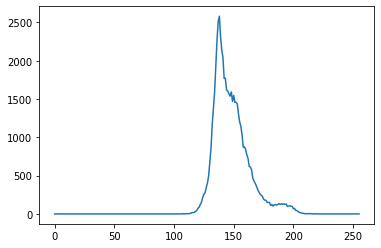

In [9]:
plt.plot (count)
#plt.bar( range(len(count)), count)

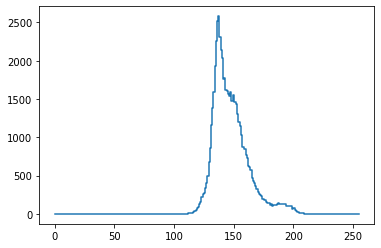

In [10]:
plt.plot (range(256), count, drawstyle='steps')

In [11]:
count > 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [12]:
left = 0
for i in range (count.size):
    if count[i] != 0:
        break
left = i
#
right = 0
for i in range (count.size-1, 0, -1):
    if count[i] != 0:
        break
right = i
print (left, right)

100 223


## Histogram Stretch
- left -> 0
- right -> 255
- linear transformation
$$
    \frac{y - y_{min}}{y_{max} - y_{min}} =     \frac{x - x_{min}}{x_{max} - x_{min}}
$$
    - $y_{min} = 0$, $y_{max} = 255$
    - $x_{min} = left$, $x_{max} = right$

In [13]:
def translate (x, xmin, xmax, ymin=0, ymax=255):
    y = (x-xmin)*(ymax-ymin) / (xmax-xmin) + ymin
    return y

In [14]:
intensity = np.array(range(256))
new_int = translate (intensity, xmin=left, xmax=right)
new_int.shape, intensity.shape
#plt.plot (new_int)

((256,), (256,))

Text(0.5, 1.0, 'linear intensity mapping function')

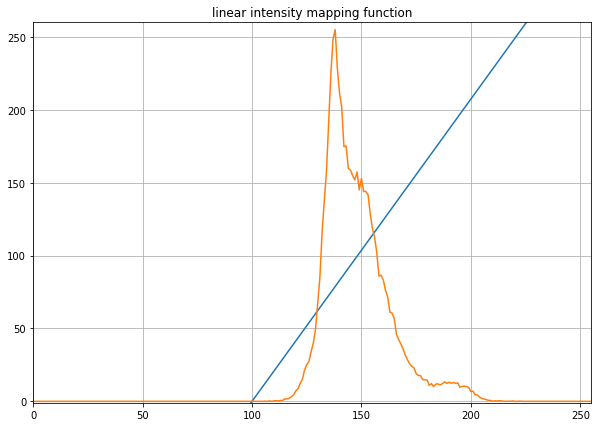

In [15]:
plt.figure(figsize=(10,7))
plt.plot (new_int)
plt.plot (count / count.max() * 255)
plt.xlim( (0, 255) )
plt.ylim( (-1, 260) )
plt.grid(True)
plt.title ('linear intensity mapping function')

In [16]:
im2 = np.empty_like (im)
im2.shape

(200, 300)

In [17]:
for r in range(im.shape[0]):
    for c in range(im.shape[1]):
        im2[r,c] = new_int[ im[r,c] ]

Text(0.5, 1.0, 'histogram after intensity stretch')

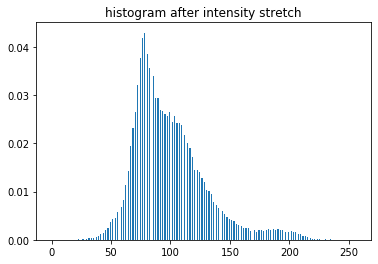

In [18]:
h2 = plt.hist (im2.ravel(), bins=256, range=(0,256), density=True)
plt.title ('histogram after intensity stretch')

<BarContainer object of 256 artists>

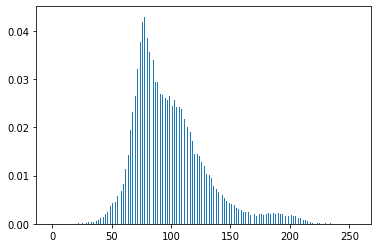

In [19]:
h2[0].shape, h2[1].shape
plt.bar(h2[1][:-1], h2[0])

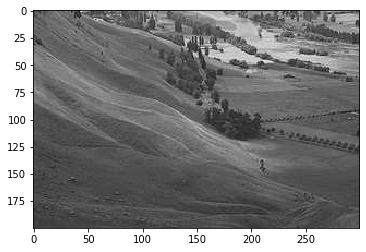

In [20]:
plt.imshow (im2, cmap='gray')

In [21]:
imageio.imwrite('histogram_stretch.png', im2)

## Histogram Equalization (Nonlinear Stretch)

cdf:  (256,)


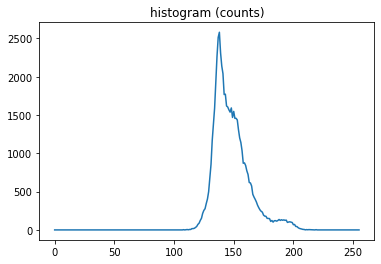

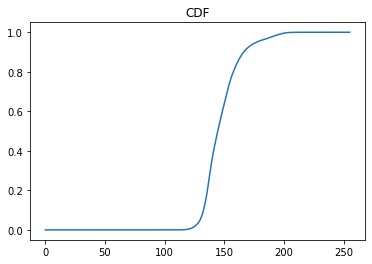

max of pmf:  0.043


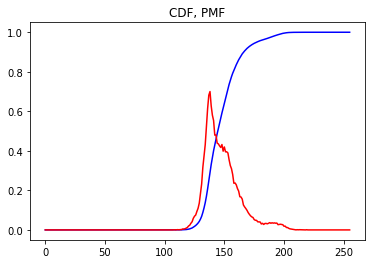

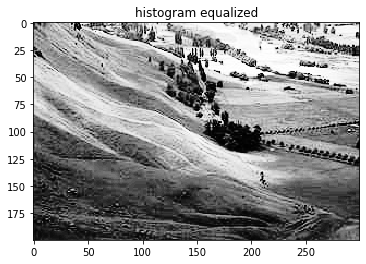

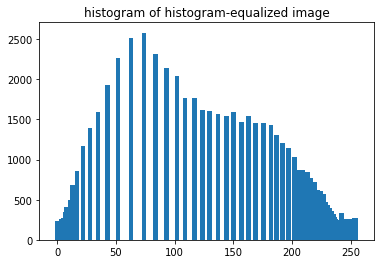

In [22]:
def histogram (ii):
    h = np.zeros(256)
    for val in ii.flatten():
        h[val] += 1
    return h
#

def make_cdf (pmf):
    cdf = np.zeros (pmf.shape)
    print ('cdf: ', cdf.shape)
    cdf[0] = pmf[0]
    for x in range(1, cdf.shape[0]):
        cdf[x] = cdf[x-1] + pmf[x]  
    return cdf
#

# compute histogram
h = histogram (im)

# normalize to get PMF, Probability Mass Function
pmf = h / float(im.shape[0]*im.shape[1])

# Accumulate to get CDF, Cumulative Distribution Function
cdf = make_cdf (pmf)

plt.plot (h); plt.title ('histogram (counts)') # show the histogram
plt.pause (1) # seconds
plt.close()

plt.plot (cdf); plt.title('CDF') # check the CDF
plt.pause (1)
plt.close()

#
pmf_max = pmf.max()
print ('max of pmf: ', pmf_max)
plt.plot (range(cdf.shape[0]), cdf, 'b-', range(cdf.shape[0]), pmf*0.7/pmf_max, 'r-'); 
plt.title ('CDF, PMF')
plt.pause(1)
plt.close()

def histogram_equalization (img, cdf):
    ieq = np.zeros_like (img)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            pixelvalue = img[r,c]
            ieq[r,c] = np.clip(255. * cdf[pixelvalue], 0, 255).astype (np.uint8)
    #
    return ieq
#

# do it now
img_eq = histogram_equalization (im, cdf)
imageio.imwrite ('img_eq.png', img_eq)
plt.imshow (img_eq, cmap='gray'); plt.title('histogram equalized')
plt.pause(1)
plt.close()

# check the histogram of the equalized image.
# verify what you did.

heq = histogram (img_eq)

plt.bar (range(0,256), heq, width=4)
plt.title('histogram of histogram-equalized image')
plt.pause (1)
plt.close()

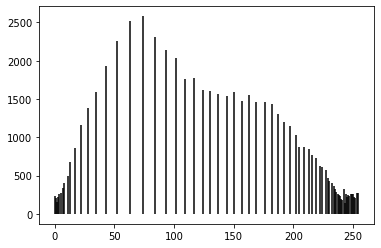

In [23]:
plt.vlines(range(256), 0, heq)

In [24]:
pmf_heq = heq / heq.sum()

In [25]:
cdf_heq = make_cdf (pmf_heq)

cdf:  (256,)


Text(0.5, 1.0, 'histogram from equalization and its cumulative (scaled for visualization)')

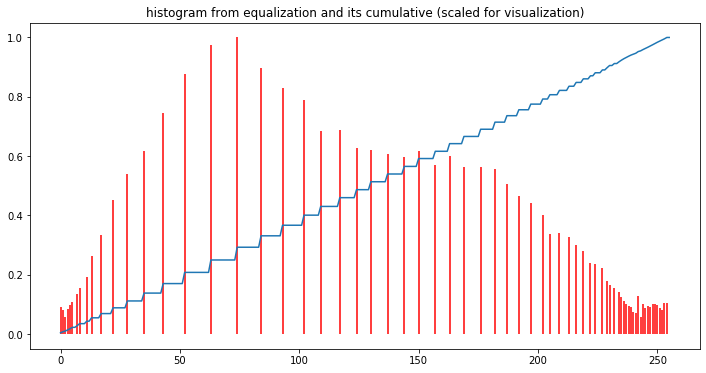

In [26]:
plt.figure (figsize=(12,6))
plt.vlines (range(256), 0, pmf_heq / pmf_heq.max(), color='r')
plt.plot (cdf_heq)
plt.title ('histogram from equalization and its cumulative (scaled for visualization)')

## END